In [20]:
#IMPORT MODULES
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
import sys
import os
from collections import defaultdict
from Bio.Blast import NCBIXML
from Bio.SeqFeature import SeqFeature
import subprocess
import gzip
import pypangraph as pp
from collections import Counter
import csv
import re
import seaborn as sns
from geopy.geocoders import Nominatim
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import nnls
from sklearn.metrics import r2_score
from scipy.stats import pearsonr



#IMPORT FILES
votu_sizes='/Users/jferrare/Documents/Good Lab Work/Gut Phage/votu_genome_counts.txt'
meta_data='/Users/jferrare/Documents/Good Lab Work/Gut Phage/uhgv_metadata.tsv.gz' #874051 rows
genomes='/Users/jferrare/Documents/Good Lab Work/Gut Phage/uhgv_mgv.fna.gz'
ani_results='/Users/jferrare/Documents/Good Lab Work/Gut Phage/combined_uhgv_mgv_ani.txt' #30700847 rows
blast_results='/Users/jferrare/Documents/Good Lab Work/Gut Phage/combined_uhgv_mgv_blast_results.txt' #165831139 rows
sequence_counts_file='/Users/jferrare/Documents/Good Lab Work/Gut Phage/February_2025/votu_sequence_counts.txt'
ani_columns=['query_id', 'subject_id', 'num_alns', 'percent_identity', 'query_coverage', 'target_coverage']
blast_columns=['query_id','subject_id','percent_identity','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore'] 
meta_columns=['uhgv_genome','uhgv_votu','votu_representative','original_study_alias','original_id','genome_length','is_jumbo_phage','gc_percent','checkv_quality','checkv_completeness','checkv_completeness_method','checkv_trimmed','viral_confidence','genomad_virus_score','genomad_virus_hallmarks','genomad_plasmid_hallmarks','viralverify_prediction','viralverify_score','checkv_viral_markers','checkv_host_markers','cds_count','cds_density','avg_cds_length','genetic_code','is_recoded','trna_count_total','trna_count_suppressor','sra_run','sra_sample','biosample','country','latitude','longitude']


In [2]:
#DEFINE FUNCTIONS
##############################################################################
#open votu sizes. first column is votu second column is size. create dictionary
votu_to_size = {}
with open(votu_sizes, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        votu_to_size[parts[0]] = int(parts[1])
    


# Load sequence-to-vOTU mapping
sequence_to_votu = {}
with gzip.open(meta_data, 'rt') as f:
    for line in f:
        if line.startswith('uhgv_genome'):
            continue
        parts = line.strip().split('\t')
        sequence_to_votu[parts[0]] = parts[1]

#define function to get continent from latitude and longitude
def get_continent(country,latitude, longitude):
    # List of European countries
    European_countries=['Netherlands','Russian Federation','Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom', 'Vatican City']
    North_american_countries=['Canada','United States','Mexico','Greenland','Belize','Guatemala','Honduras','El Salvador','Nicaragua','Costa Rica','Panama','Jamaica','Haiti','Dominican Republic','Cuba','Bahamas','Barbados','Saint Lucia','Saint Vincent and the Grenadines','Grenada','Trinidad and Tobago','Saint Kitts and Nevis','Antigua and Barbuda','Dominica','Saint Martin','Sint Maarten','Saint Barthelemy','Anguilla','Montserrat','Guadeloupe','Martinique','Saint Pierre and Miquelon','Bermuda','Turks and Caicos Islands','Cayman Islands','British Virgin Islands','United States Virgin Islands','Puerto Rico','Dominican Republic','Haiti','Cuba','Jamaica','Bahamas','Turks and Caicos Islands','Honduras','Nicaragua','Costa Rica','Panama','Belize','Guatemala','El Salvador','Mexico','Canada','United States']
    South_american_countries=['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Guyana','Paraguay','Peru','Suriname','Uruguay','Venezuela']
    Asian_countries=['China','Kazakhstan','Mongolia','India','Bangladesh','Pakistan','Afghanistan','Tajikistan','Kyrgyzstan','Uzbekistan','Turkmenistan','Iran','Iraq','Syria']
    African_countries=['Tanzania, United Republic of']
    
    if country in African_countries:
        return 'Africa'

    elif country in Asian_countries:
        return 'Asia'

    elif country in European_countries:
        return 'Europe'

    elif country in North_american_countries:
        return 'North America'

    elif country in South_american_countries:
        return 'South America'
        
    # North America
    elif 23.0 < latitude <= 60.0 and -135.0 <= longitude <= -60.0:
        return "North America"
    
    # South America
    elif -56.0 <= latitude <= 15.0 and -90.0 <= longitude <= -30.0:
        return "South America"
    
    # Europe
    elif 30.0 <= latitude <= 85.0 and -15.0 < longitude < 45.0:
        return "Europe"
    
    # Asia
    elif 0.0 <= latitude <= 77.0 and 45.0 <= longitude <= 165.0:
        return "Asia"
    
    # Africa
    elif -30.0 <= latitude < 30.0 and 15.0 <= longitude < 45.0:
        return "Africa"
    
    # If not within any of the above bounds
    else:
        return "Continent not recognized"
    
# Function to extract vOTUs from filenames in a given folder
def extract_votus(folder_path):
    votus = []
    ns = []
    
    # Iterate over files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".fna"):
            # Extract vOTU part from the filename (before the first underscore)
            votu = filename.split('_')[0]
            n = filename.split('_')[1].split('.')[0][1::]
            votus.append(votu)
            ns.append(int(n))
    
    return votus, ns


In [6]:
# EXTRACT VOTU, CONTINENT, LATITUDE, AND LONGITUDE FOR EACH SEQUENCE
##############################################################################
sequences_ids = set()
sequences=[]
votus=[]

# Read genomes file and store sequence IDs in the set
with gzip.open(genomes, 'rt') as f:
    sequences_ids = {record.id for record in SeqIO.parse(f, 'fasta')}

# Initialize lists for latitudes and longitudes
lats, longs, votus, continents, countries = [], [], [] , [], []

# Read the metadata file and process only the relevant rows
with gzip.open(meta_data, 'rt') as f:
    for line in f:
        line = line.strip().split('\t')
        if line[0] in sequences_ids:  # Faster set lookup
            try:
                country=line[-3]
                try:
                    lat=float(line[-2])
                    long=float(line[-1])
                except:
                    lat=10000
                    long=10000
                continent=get_continent(country,lat,long)
                votu=sequence_to_votu[line[0]]

                #append data
                sequences.append(line[0])
                continents.append(continent)
                lats.append(lat)  # Assuming latitudes are numeric
                longs.append(long)  # Assuming longitudes are numeric
                votus.append(votu)
                countries.append(country)
            except:
                print(line)
                sequences.append(line[0])
                continents.append(0)
                votus.append(0)
                lats.append(0)  # Assuming latitudes are numeric
                longs.append(0)  # Assuming longitudes are numeric



In [7]:
#IDENTIFY VOTUS BY CONTINENT/COUNTRY AND SAVE TO FILE
##############################################################################
import pandas as pd
from collections import defaultdict

# Create a DataFrame from the collected data
data = pd.DataFrame({
    'sequence': sequences,
    'votu': votus,
    'continent': continents,
    'country': countries
})

# Count sequences per vOTU and continent
count_table_continent = data.groupby(['votu', 'continent']).size().unstack(fill_value=0)
count_table_country = data.groupby(['votu', 'country']).size().unstack(fill_value=0)
# Save to a file or display
count_table_continent.to_csv('/Users/jferrare/Documents/Good Lab Work/Gut Phage/votu_continent_counts.csv')
count_table_country.to_csv('/Users/jferrare/Documents/Good Lab Work/Gut Phage/votu_country_counts.csv')


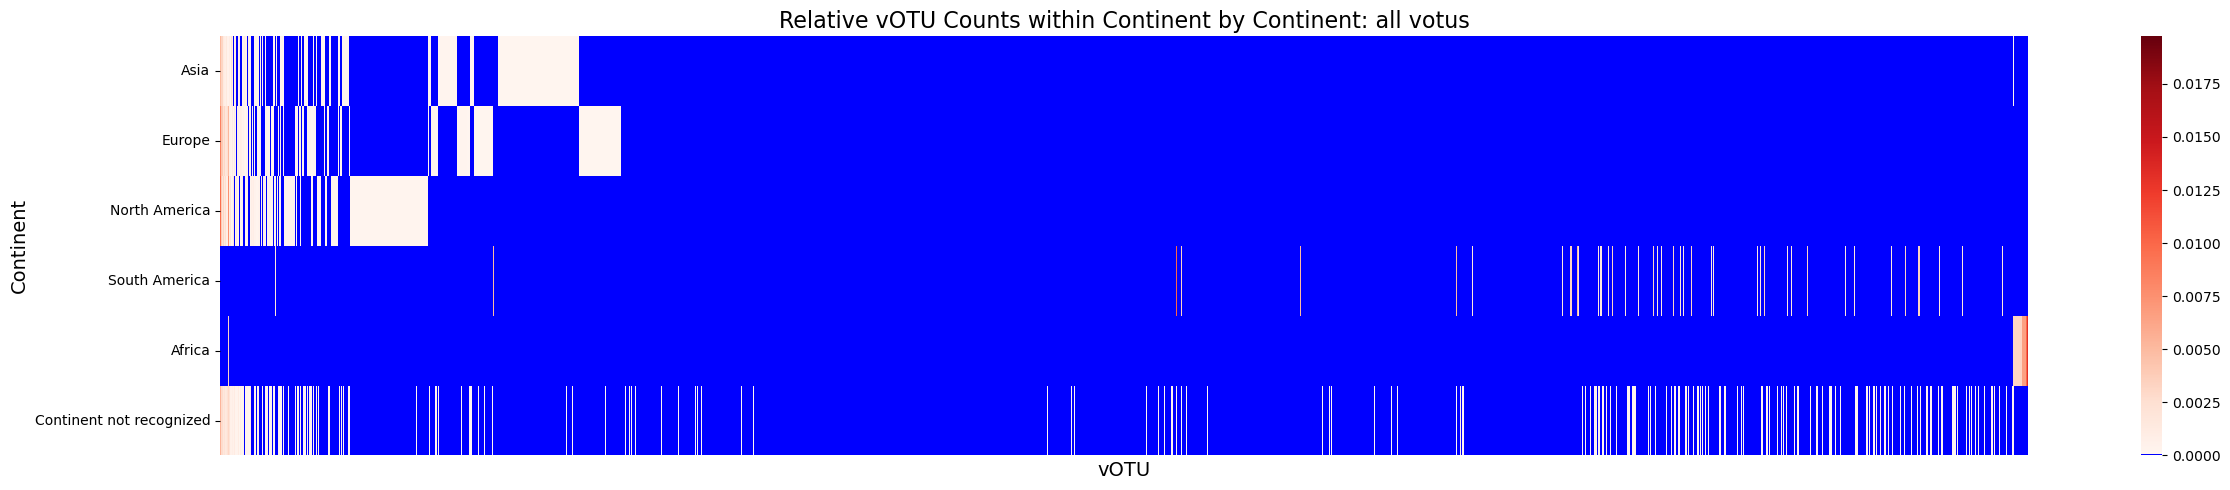

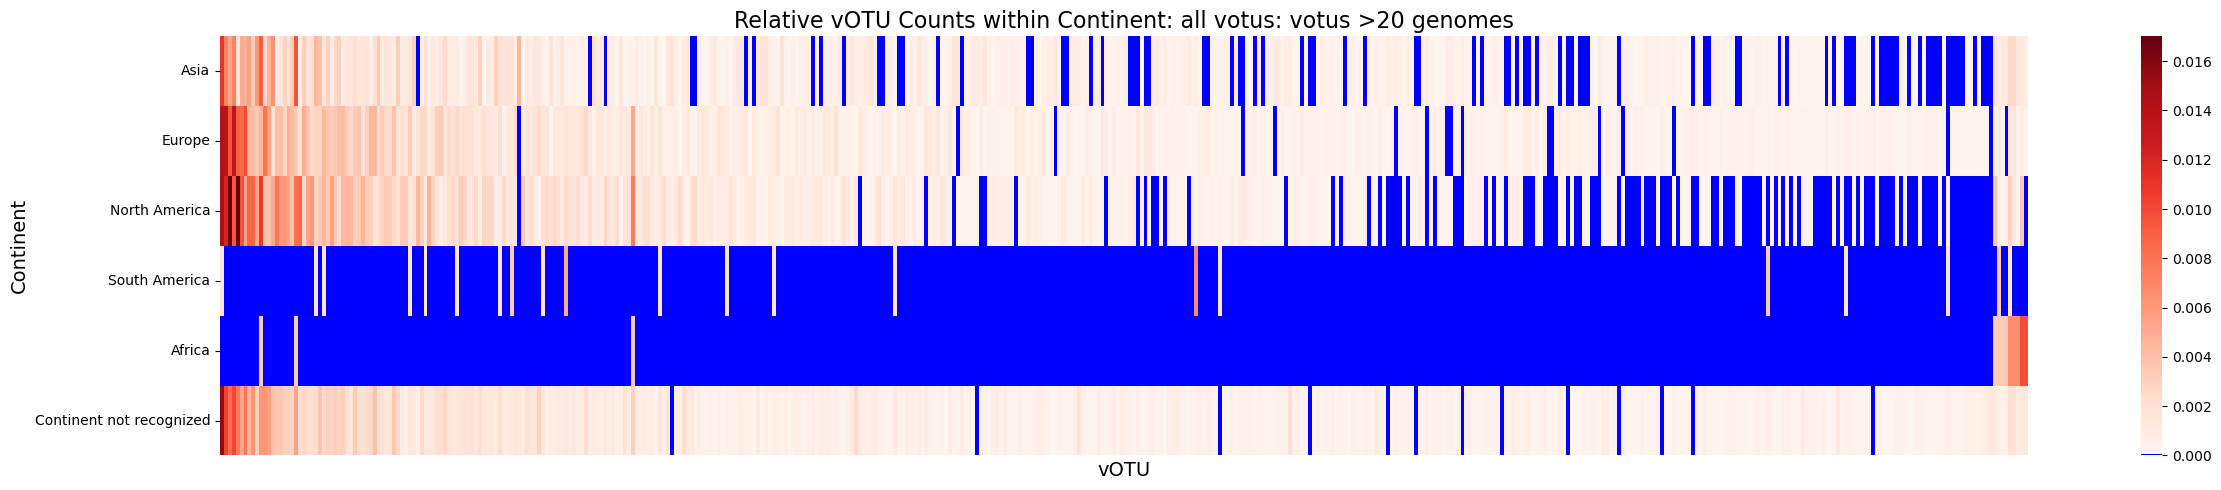

In [8]:
#PLOT RELATIVE VOTU COUNTS BY CONTINENT
##############################################################################
cmap1 = LinearSegmentedColormap.from_list("grey_reds", [(0, 'blue'), (0.001, 'white')] + [(x, plt.cm.Reds(x)) for x in np.linspace(0.001, 1, 256)])
filtered_table = count_table_continent.div(count_table_continent.sum(axis=0), axis=1)
# Move Africa to the bottom
africa_data = filtered_table['Africa']
filtered_table = filtered_table.drop('Africa', axis=1)
filtered_table['Africa'] = africa_data
#move Continent not recognized to the bottom
continent_not_recognized_data = filtered_table['Continent not recognized']
filtered_table = filtered_table.drop('Continent not recognized', axis=1)
filtered_table['Continent not recognized'] = continent_not_recognized_data

#sort by average value in 'Europe','North America' and 'Asia' - average value in 'Africa' and 'South America'
# Calculate average values for 'Europe', 'North America', and 'Asia'
continent_avg = filtered_table[['Europe', 'North America', 'Asia']].mean(axis=1)

# Calculate average values for 'Africa' and 'South America' (to use for sorting)
other_continent_avg = filtered_table[['Africa']].mean(axis=1)

#subtract other_continent_avg from continent_avg
continent_avg=continent_avg-other_continent_avg
#sort votus in filtered table by continent_avg
filtered_table = filtered_table.loc[continent_avg.sort_values(ascending=False).index]
#remove votus in filtered_table with votu_to_size[votu]<20
filtered_table_large=filtered_table[filtered_table.index.map(lambda x: votu_to_size[x]>=20)]


# Create a heatmap with log color scale
plt.figure(figsize=(25, 5))
sns.heatmap(
    filtered_table.transpose(), 
    cmap=cmap1
)

# Add labels and title
plt.title('Relative vOTU Counts within Continent by Continent: all votus', fontsize=16)
plt.xlabel('vOTU', fontsize=14)
plt.ylabel('Continent', fontsize=14)

#no xticks
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()
# Create a heatmap with log color scale
plt.figure(figsize=(25, 5))
sns.heatmap(
    filtered_table_large.transpose(), 
    cmap=cmap1
)

# Add labels and title
plt.title('Relative vOTU Counts within Continent: all votus: votus >20 genomes', fontsize=16)
plt.xlabel('vOTU', fontsize=14)
plt.ylabel('Continent', fontsize=14)

#no xticks
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()




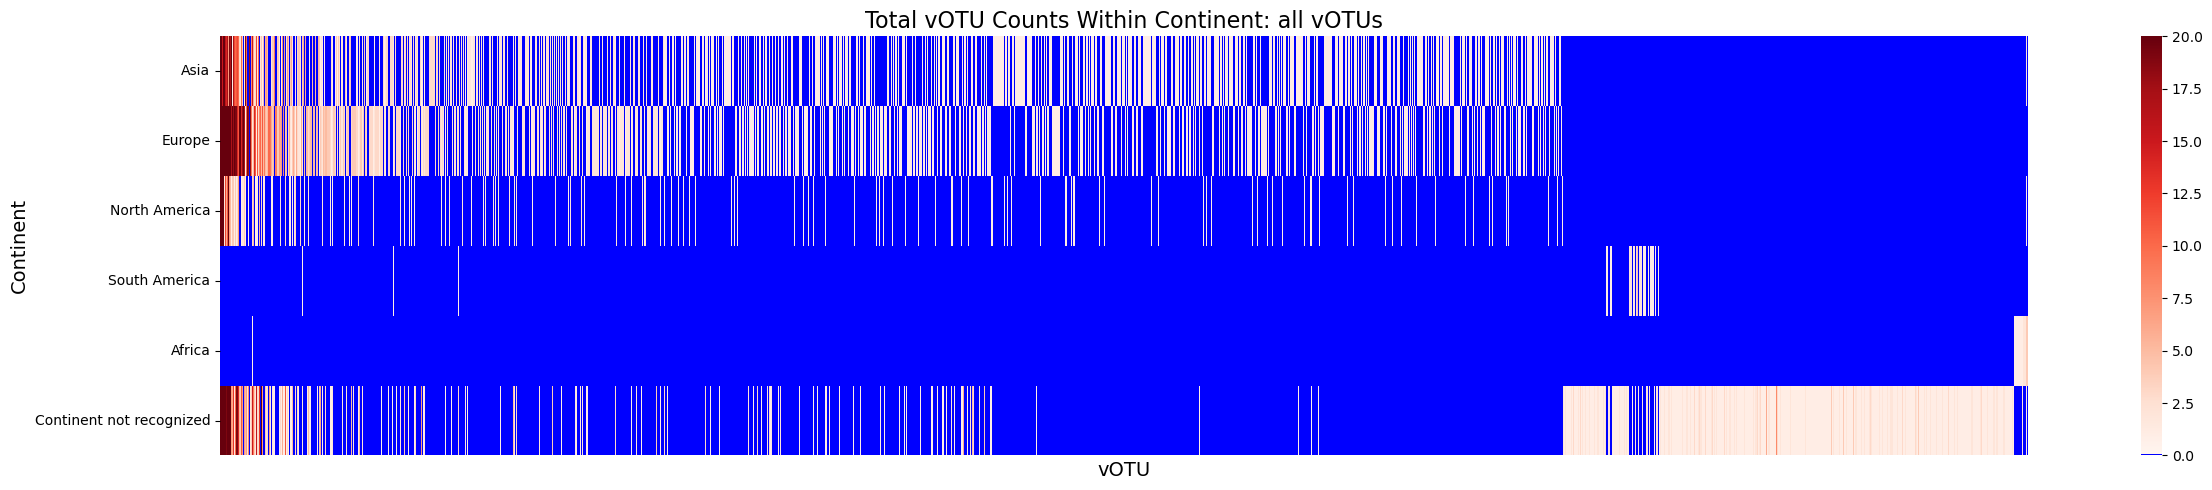

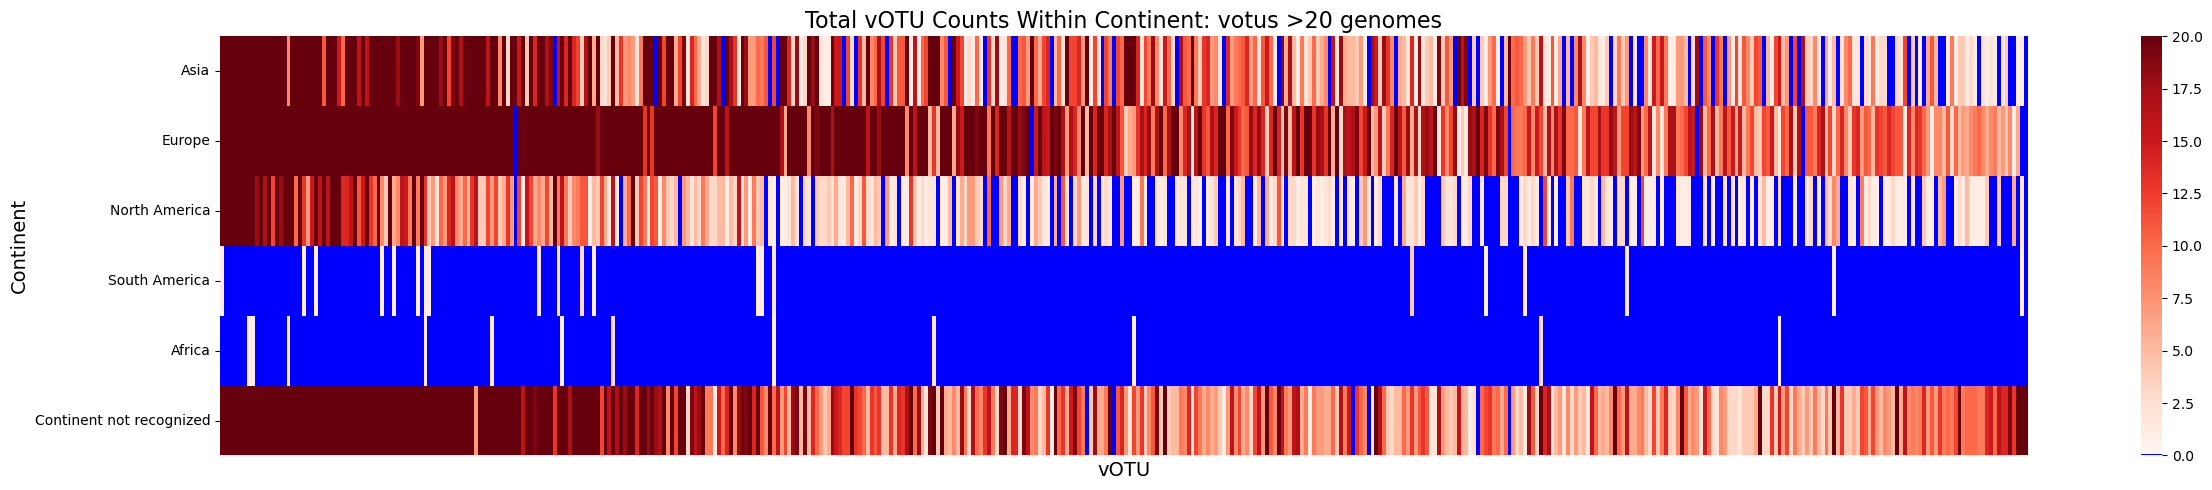

In [9]:
#PLOT RAW VOTU COUNTS BY CONTINENT
##############################################################################
filtered_table=count_table_continent[(count_table_continent>0).any(axis=1)]
# Move Africa to the bottom
africa_data = filtered_table['Africa']
filtered_table = filtered_table.drop('Africa', axis=1)
filtered_table['Africa'] = africa_data
#move Continent not recognized to the bottom
continent_not_recognized_data = filtered_table['Continent not recognized']
filtered_table = filtered_table.drop('Continent not recognized', axis=1)
filtered_table['Continent not recognized'] = continent_not_recognized_data

continent_avg = filtered_table[['Europe', 'North America', 'Asia']].mean(axis=1)

# Calculate average values for 'Africa' and 'South America' (to use for sorting)
other_continent_avg = filtered_table[['Africa', 'South America']].mean(axis=1)

#subtract other_continent_avg from continent_avg
continent_avg=other_continent_avg
#sort votus in filtered table by continent_avg
filtered_table = filtered_table.loc[continent_avg.sort_values(ascending=False).index]
#sort by average value in 'Europe','North America' and 'Asia' - average value in 'Africa' and 'South America'

# Calculate average values for 'Europe', 'North America', and 'Asia'
continent_avg = filtered_table[['Europe', 'North America', 'Asia']].mean(axis=1)

# Calculate average values for 'Africa' and 'South America' (to use for sorting)
other_continent_avg = filtered_table[['Africa']].mean(axis=1)

#subtract other_continent_avg from continent_avg
continent_avg=continent_avg-other_continent_avg
#sort votus in filtered table by continent_avg
filtered_table = filtered_table.loc[continent_avg.sort_values(ascending=False).index]

#remove votus in filtered_table with votu_to_size[votu]<5
filtered_table_large=filtered_table[filtered_table.index.map(lambda x: votu_to_size[x]>=5)]

# Create a heatmap with log color scale
plt.figure(figsize=(25, 5))
sns.heatmap(
    filtered_table.transpose(), 
    cmap=cmap1,
    vmin=0,
    vmax=20
)

# Add labels and title
plt.title('Total vOTU Counts Within Continent: all vOTUs', fontsize=16)
plt.xlabel('vOTU', fontsize=14)
plt.ylabel('Continent', fontsize=14)

#no xticks
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()

#remove votus in filtered_table with votu_to_size[votu]<20
filtered_table_large=filtered_table[filtered_table.index.map(lambda x: votu_to_size[x]>=20)]

# Create a heatmap with log color scale
plt.figure(figsize=(25, 5))
sns.heatmap(
    filtered_table_large.transpose(), 
    cmap=cmap1,
    vmin=0,
    vmax=20
)

# Add labels and title
plt.title('Total vOTU Counts Within Continent: votus >20 genomes', fontsize=16)
plt.xlabel('vOTU', fontsize=14)
plt.ylabel('Continent', fontsize=14)

#no xticks
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()

441


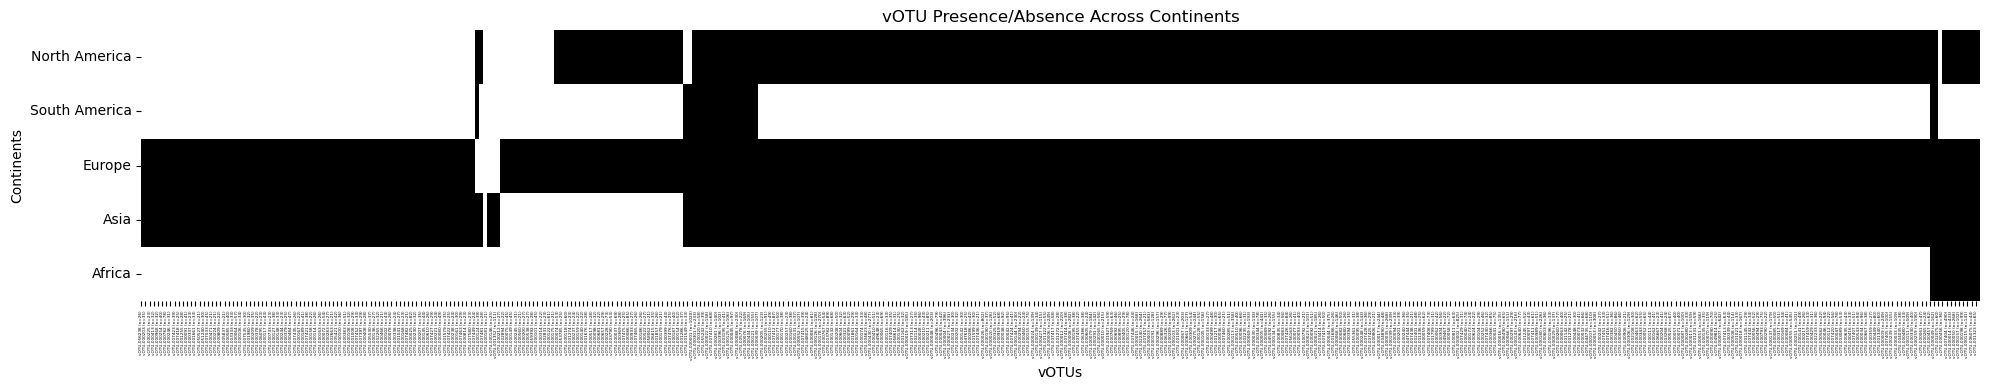

In [10]:
#PLOT VOTU ABSENCE/PRESENCE ACROSS CONTINENTS
#--->This code is now redunant but leaving for now
##############################################################################

folder_path = "/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTUs"
votu_list, ns_list = extract_votus(folder_path)


# Initialize binary columns for each continent
votu_continents = {votu: {'North America': 0, 'South America': 0, 'Europe': 0, 'Asia': 0} for votu in votu_list}

# Iterate over sequences and assign continent columns based on coordinates
for seq, lat, lon, country in zip(sequences, lats, longs, countries):
    votu = sequence_to_votu[seq]
    continent = get_continent(country,lat, lon)
    if continent in ['North America', 'South America', 'Europe', 'Asia', 'Africa'] and votu in votu_list:
        votu_continents[votu][continent] = 1

# Create a DataFrame for the heatmap
heatmap_data = []

# Fill the heatmap_data list with 1 or 0 for each vOTU and continent
for continent in ['North America', 'South America', 'Europe', 'Asia', 'Africa']:
    continent_data = []
    for votu in votu_list:
        continent_data.append(votu_continents.get(votu, {}).get(continent, 0))
    heatmap_data.append(continent_data)

# Convert the list into a DataFrame for easier visualization
heatmap_df = pd.DataFrame(heatmap_data, columns=votu_list, index=['North America', 'South America', 'Europe', 'Asia', 'Africa'])

# Perform hierarchical clustering on vOTUs based on their continent presence
votu_similarity = linkage(heatmap_df.T, method='ward', metric='euclidean')  # Perform hierarchical clustering
ordered_votus = heatmap_df.columns[leaves_list(votu_similarity)].to_list()  # Get ordered vOTUs

# Reorder the DataFrame columns based on clustering results
heatmap_df = heatmap_df[ordered_votus]

# Modify the x-axis labels to include n values
ordered_ns = [ns_list[votu_list.index(votu)] for votu in ordered_votus]
ordered_votu_labels = [f"{votu} (n={n})" for votu, n in zip(ordered_votus, ordered_ns)]
print(len(ordered_votu_labels))
# Create the heatmap
plt.figure(figsize=(20, 4))
sns.heatmap(heatmap_df, cmap='binary', cbar=False, linecolor='red', annot=False)

# Set labels and title
#make xtickslabel fontsize smaller
plt.subplots_adjust(bottom=.5)
plt.xticks(fontsize=3)
plt.xlabel("vOTUs")
plt.ylabel("Continents")
plt.title("vOTU Presence/Absence Across Continents")

# Update x-axis with labels that include 'n'
plt.xticks(ticks=np.arange(len(ordered_votu_labels)), labels=ordered_votu_labels, rotation=90)

# Show the heatmap
plt.tight_layout()
plt.show()


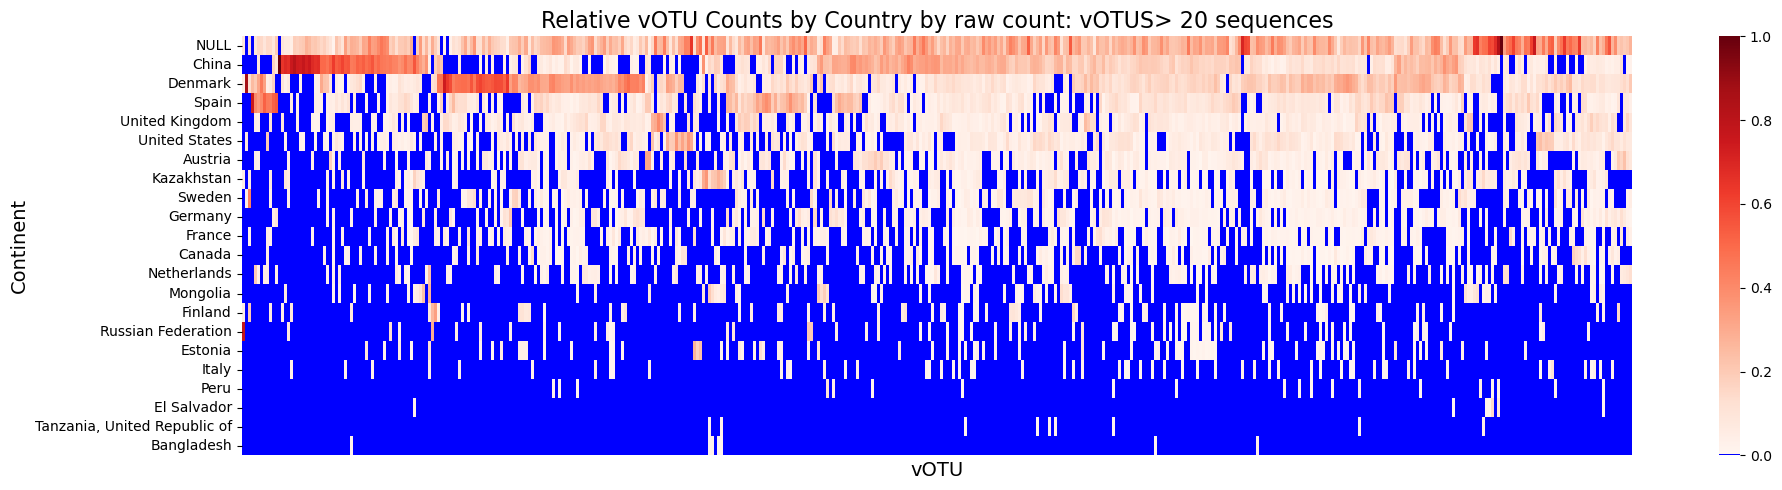

In [216]:
#PLOT RELATIVE ABUNDANCE OF VOTU PAIRS BY COUNTRY
##############################################################################

count_table=count_table_country[(count_table_country>0).any(axis=1)]

#obtian votus with core sharing
votu_pairs = []
votus_w_shared_core=[]
folder='/Users/jferrare/Documents/Good Lab Work/Gut Phage/March_2025/Combined_vOTU_sequences'
for file in os.listdir(folder):
    if file.endswith('.fna'):
        name1=file.split('_')[-2]
        name2=file.split('_')[-1].split('.')[0]
        votus_w_shared_core.append(name1)
        votus_w_shared_core.append(name2)
        votu_pairs.append((name1,name2))


#subset count_table as count_table_subset to rows with a votu in votu_pairs
#count_table_subset=count_table[count_table.index.isin(votus_w_shared_core)]
count_table_subset=count_table
count_table_subset=count_table[count_table.index.map(lambda x: votu_to_size[x]>=20)]
#normalize counts by row
count_table_norm = count_table_subset.div(count_table_subset.sum(axis=1), axis=0)
#sort rows of count_table_norm by sum of row
sums=count_table_norm.sum(axis=0)
count_table_norm=count_table_norm.loc[:,sums.sort_values(ascending=False).index]
#remove null country
count_table_norm_no_null=count_table_norm.drop('NULL', axis=1)
# Compute pairwise distances between vOTUs based on their normalized country profiles
distance_matrix = pdist(count_table_norm_no_null.values, metric='euclidean')
# Perform hierarchical clustering on the vOTUs
linkage_matrix = linkage(distance_matrix, method='average')
# Get the order of rows (vOTUs) based on clustering
row_order = leaves_list(linkage_matrix)
# Reorder rows in count_table_norm
count_table_norm = count_table_norm.iloc[row_order, :]



#plot a heat map of the normalized count_table
plt.figure(figsize=(20, 5))
sns.heatmap(
    count_table_norm.transpose(), 
    cmap=cmap1
)
# Add labels and title
plt.title('Relative vOTU Counts by Country by raw count: vOTUS> 20 sequences', fontsize=16)
plt.xlabel('vOTU', fontsize=14)
plt.ylabel('Continent', fontsize=14)
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()


{'Austria': 0.0338043637557046, 'Bangladesh': 0.0011815606527996105, 'Canada': 0.031951237879729213, 'China': 0.2516478769933863, 'Denmark': 0.1622584239295667, 'El Salvador': 0.0071636185639651385, 'Estonia': 0.014298391287036163, 'Finland': 0.007257252244745135, 'France': 0.0372290330791465, 'Germany': 0.044283982679342665, 'Italy': 0.0, 'Kazakhstan': 0.009999624930430015, 'Mongolia': 0.01082054753505059, 'Netherlands': 0.0, 'Peru': 0.0032532070248782506, 'Russian Federation': 0.007271049995848147, 'Spain': 0.10718343151469086, 'Sweden': 0.02897430816377771, 'Tanzania, United Republic of': 0.00258240016529299, 'United Kingdom': 0.06904106316905186, 'United States': 0.10150086444628288}
{'Austria': 0.03910921964999817, 'Bangladesh': 0.0013024177275562242, 'Canada': 0.019206075503540376, 'China': 0.2843489745753384, 'Denmark': 0.21170708441868144, 'El Salvador': 0.0013207616392119455, 'Estonia': 0.01001577576402392, 'Finland': 0.012767362512382141, 'France': 0.02292988956965183, 'Germa

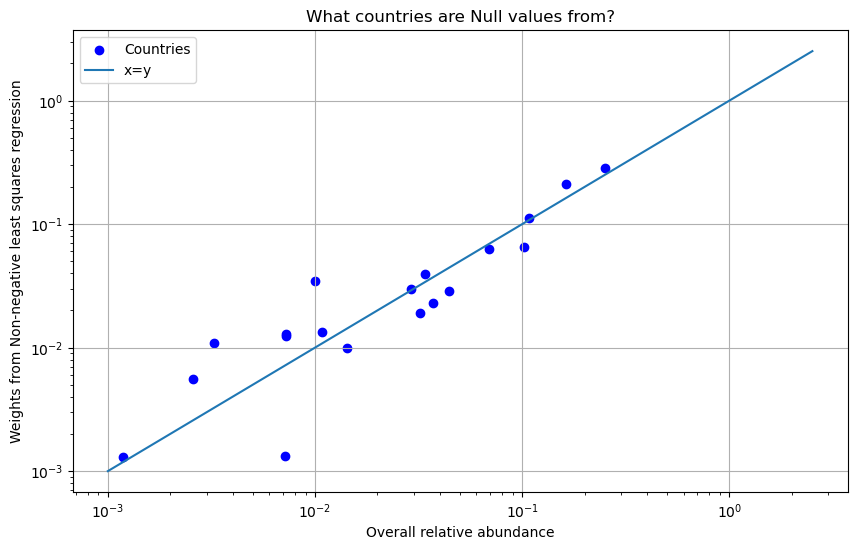

In [220]:
#REGRESS TO FIND DISTRIBUTION OF NULL COUNTRY
##############################################################################
from scipy.optimize import nnls
# Remove rows with zero counts in all columns
count_table=count_table_country[count_table_country.index.map(lambda x: votu_to_size[x]>=1)]
count_table_no_null=count_table.drop('NULL', axis=1)
#relative abundance of samples from different countries
sums=count_table_no_null.sum(axis=0)
sums=sums/np.sum(sums)
country_norms=sums.to_dict()

count_table= count_table[(count_table > 0).any(axis=1)]
count_table = count_table.div(count_table.sum(axis=0), axis=1)

count_table=count_table.T
X = count_table.drop('NULL', axis=0).T  # Transpose to get countries as columns (462 samples, 21 features)
y = count_table.loc['NULL']  # NULL country (462 values)


# Fit the model using non-negative least squares
# scipy's nnls function ensures coefficients are non-negative
coefficients, _ = nnls(X, y)
# Create dictionary with weights for each country (ensured to be non-negative)
country_weights = dict(zip(X.columns, coefficients))


# Print the dictionary
print(country_weights)
print(country_norms)

# You can predict NULL values using the non-negative coefficients
y_pred = X.dot(coefficients)

# Calculate R-squared to see how well the model fits
print(f"R-squared: {r2_score(y, X.dot(nnls(X, y)[0]))}")



plt.figure(figsize=(10, 6))
plt.scatter(country_weights.values(), country_norms.values(), color='blue', label='Countries')
plt.xscale('log')
plt.yscale('log')
plt.plot(np.logspace(-3,.4,10),np.logspace(-3,.4,10),label='x=y')
plt.xlabel('Overall relative abundance')
plt.ylabel('Weights from Non-negative least squares regression')
plt.title('What countries are Null values from?')
plt.grid(True)
plt.legend()
plt.show()


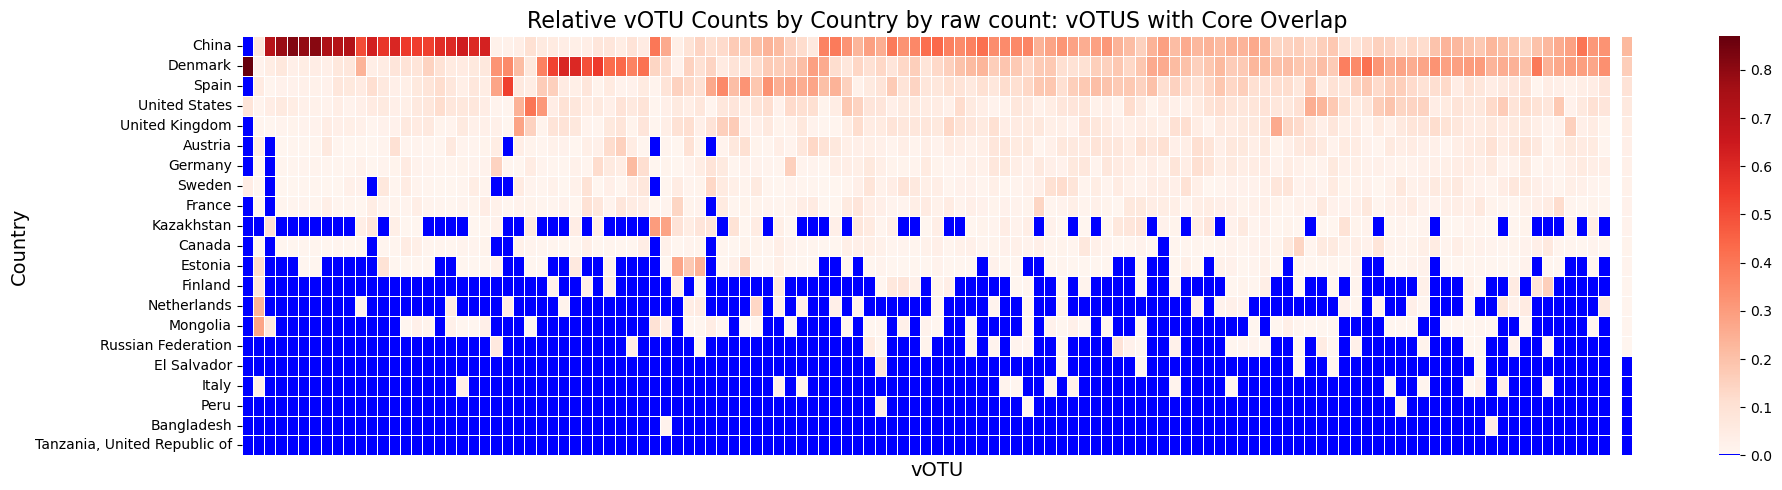

In [226]:
#PLOT RELATIVE ABUNDANCE OF VOTU PAIRS BY COUNTRY
##############################################################################


count_table=count_table_country[(count_table_country>0).any(axis=1)]


#obtian votus with core sharing
votu_pairs = []
votus_w_shared_core=[]
folder='/Users/jferrare/Documents/Good Lab Work/Gut Phage/March_2025/Combined_vOTU_sequences'
for file in os.listdir(folder):
    if file.endswith('.fna'):
        name1=file.split('_')[-2]
        name2=file.split('_')[-1].split('.')[0]
        votus_w_shared_core.append(name1)
        votus_w_shared_core.append(name2)
        votu_pairs.append((name1,name2))


#subset count_table as count_table_subset to rows with a votu in votu_pairs
count_table_subset=count_table[count_table.index.isin(votus_w_shared_core)]
#normalize counts by row
count_table_norm = count_table_subset.div(count_table_subset.sum(axis=1), axis=0)
for country in country_weights.keys():
    count_table_norm[country]=count_table_norm[country]+count_table_norm['NULL']*country_weights[country]

#sort rows of count_table_norm by sum of row
sums=count_table_norm.sum(axis=0)
#normalize sums
sums=sums/sums.sum()
count_table_norm=count_table_norm.loc[:,sums.sort_values(ascending=False).index]
count_table_norm_no_null=count_table_norm.drop('NULL', axis=1)
# Compute pairwise distances between vOTUs based on their normalized country profiles
distance_matrix = pdist(count_table_norm_no_null.values, metric='euclidean')
# Perform hierarchical clustering on the vOTUs
linkage_matrix = linkage(distance_matrix, method='average')
# Get the order of rows (vOTUs) based on clustering
row_order = leaves_list(linkage_matrix)
# Reorder rows in count_table_norm
count_table_norm = count_table_norm_no_null.iloc[row_order, :]


# Add a spacer row filled with NaNs for the visual gap
spacer_row = pd.DataFrame(np.nan, index=["Spacer"], columns=count_table_norm.columns)

# Add the sums row at the bottom
sums_row = pd.DataFrame([sums], index=["Sum"], columns=count_table_norm.columns)

# Combine the original data, spacer, and sums row
count_table_norm = pd.concat([count_table_norm, spacer_row, sums_row])

# Plot the heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(
    count_table_norm.transpose(),
    cmap=cmap1,
    linewidths=0.5  # Subtle line separators for clarity
)

# Add labels and title
plt.title('Relative vOTU Counts by Country by raw count: vOTUS with Core Overlap', fontsize=16)
plt.xlabel('vOTU', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Hide x-axis ticks
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()



/var/folders/fr/9592jx_j7bxf_yfy_gsb0g_c0000gn/T/ipykernel_35349/3816676510.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  count_table_pairs = pd.concat([count_table_pairs, row1.to_frame().T, row2.to_frame().T])


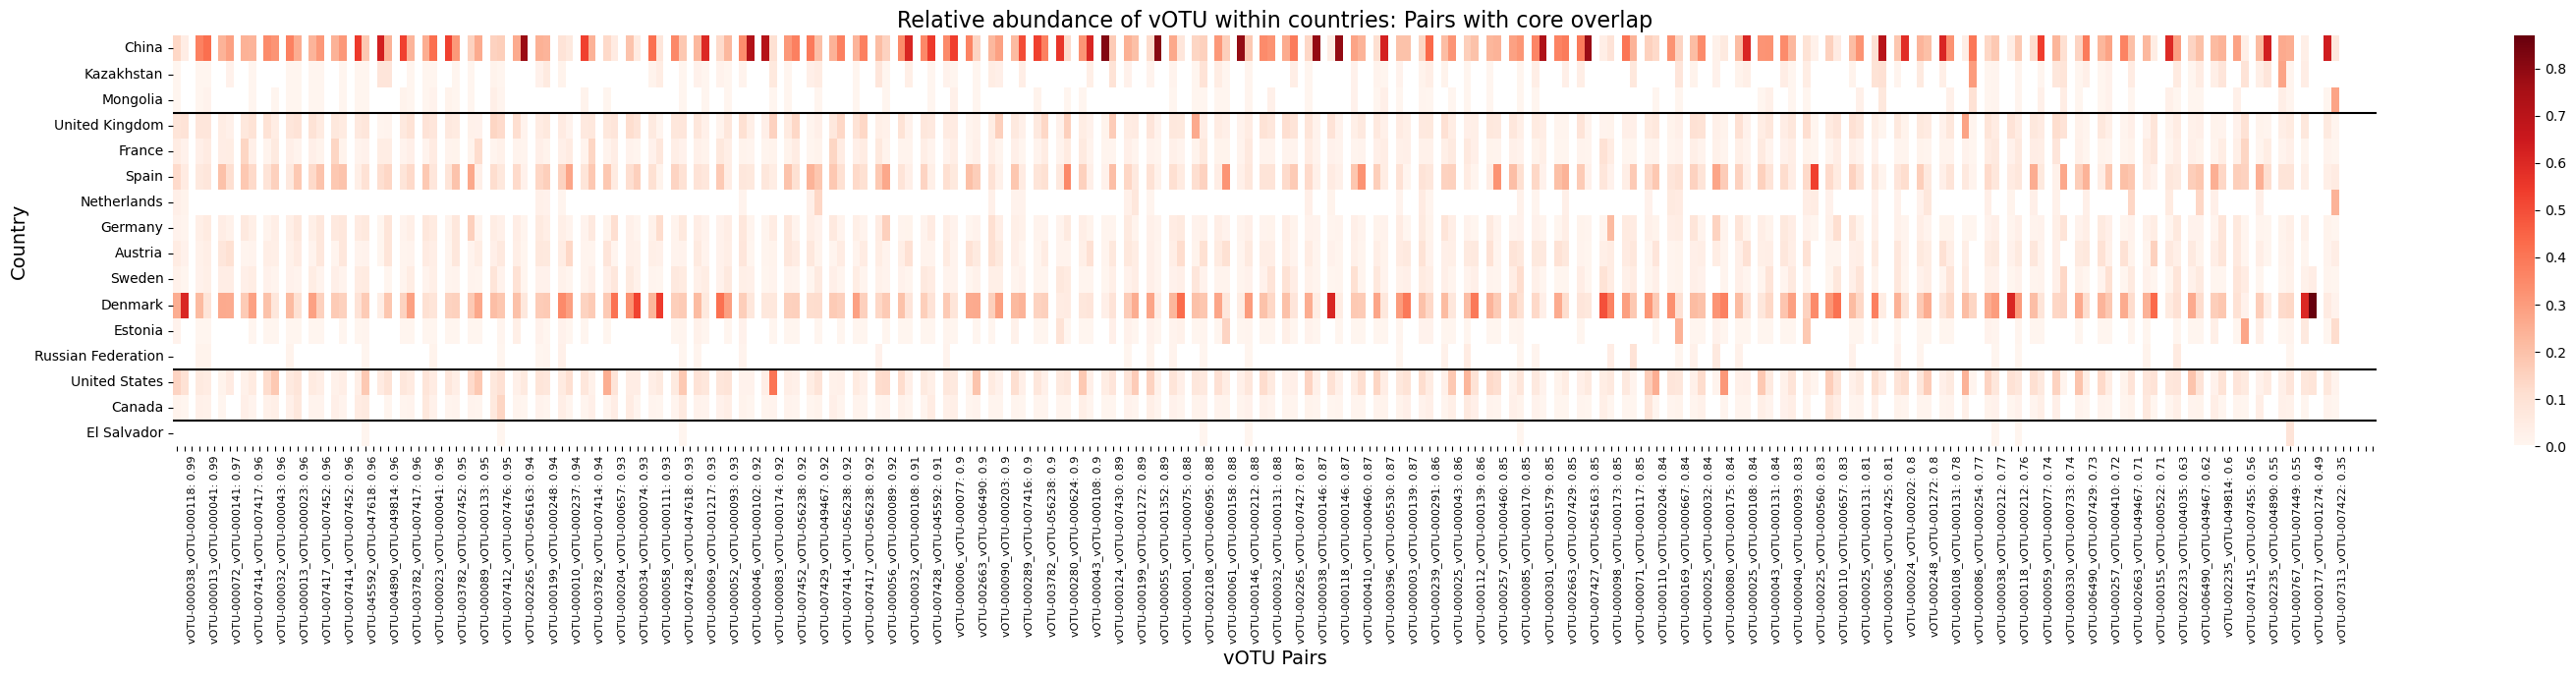

In [227]:
from scipy import stats

cmap2 = LinearSegmentedColormap.from_list("grey_reds", [(0, 'white'),(0, 'white'), (0.001, 'white')] + [(x, plt.cm.Reds(x)) for x in np.linspace(0.001, 1, 256)])
cmap2.set_bad(color='white')



# Create a list to hold rows in the desired order
ordered_rows = []

# Create an empty DataFrame to store the reordered matrix
count_table_pairs = pd.DataFrame(columns=count_table_norm.columns)

corr_vals=[]
p_vals=[]
# Build the new row order: pair1, pair2, spacer, repeat
for v1, v2 in votu_pairs:
    if v1 in count_table_norm.index and v2 in count_table_norm.index:
        # Subset count_table_norm to rows with v1 and v2
        row1 = count_table_norm.loc[v1]
        row2 = count_table_norm.loc[v2]
        # Calculate the Pearson correlation coefficient between row1 and row2
        corr, p_value = stats.spearmanr(row1, row2)
        corr_vals.append(corr)
        p_vals.append(p_value)

#reorder voty pairs by corr_vals
votu_pairs=[x for _,x in sorted(zip(corr_vals,votu_pairs), reverse=True)]

# Build the new row order: pair1, pair2, spacer, repeat
for v1, v2 in votu_pairs:
    if v1 in count_table_norm.index and v2 in count_table_norm.index:
        # Subset count_table_norm to rows with v1 and v2
        row1 = count_table_norm.loc[v1]
        row2 = count_table_norm.loc[v2]
        
        # Add the pair rows
        count_table_pairs = pd.concat([count_table_pairs, row1.to_frame().T, row2.to_frame().T])
        
        # Calculate the Pearson correlation coefficient between row1 and row2
        corr, p_value = stats.spearmanr(row1, row2)
        
        # Round the correlation to 2 decimal places
        corr = round(corr, 2)
        
        # Add an empty spacer row with the correlation value
        spacer_row = pd.DataFrame(np.nan, index=[f"{v1}_{v2}: {corr}"], columns=count_table_norm.columns)
        count_table_pairs = pd.concat([count_table_pairs, spacer_row])




#filtering
#remove countries with no value above .05
count_table_pairs=count_table_pairs[count_table_pairs.columns[count_table_pairs.max()>0.05]]
#only show first 5 countries in count_table_pairs

#sort by continent
# Build the reordered list with spacers
# Define continents and add spacer labels
continent_groups = {
    "Asia": ['China', 'Kazakhstan', 'Mongolia'],
    "Europe": ['United Kingdom', 'France', 'Spain', 'Netherlands', 'Germany', 'Austria', 'Sweden', 'Denmark', 'Estonia', 'Russian Federation'],
    "North America": ['United States', 'Canada'],
    "Central America": ['El Salvador']
}
ordered_countries_with_spacers = []
for continent, countries in continent_groups.items():
    ordered_countries_with_spacers.extend(countries)
    ordered_countries_with_spacers.append(f'--- {continent} ---')  # Add spacer row
# Create a DataFrame with gaps
for spacer in [c for c in ordered_countries_with_spacers if '---' in c]:
    count_val=0
    if count_val % 2 == 0:
        count_table_pairs.loc[spacer] = np.nan
    else:
        count_table_pairs[spacer] = 0
    count_val+=1
# Reorder the columns (countries) based on the list with spacers
count_table_pairs = count_table_pairs[[c for c in ordered_countries_with_spacers if c in count_table_pairs.columns]]
#print numver of votu pairs


# Plot the heatmap
plt.figure(figsize=(30, 7))
sns.heatmap(
    count_table_pairs.T, 
    cmap=cmap2,
    linewidths=0,  # Ensure the spacers are clearly visible

)
# Add labels and title
plt.title('vOTU Pair Heatmap with Spacers', fontsize=16)
plt.ylabel('Country', fontsize=14)
plt.xlabel('vOTU Pairs', fontsize=14)
# Only label spacer rows
plt.axhline(3, color='black')
plt.axhline(13, color='black')
plt.axhline(15, color='black')
new_labels = [label if '_' in label else '' for label in count_table_pairs.index]
plt.xticks(ticks=np.arange(len(new_labels)) + 0.5, labels=new_labels, rotation=0, fontsize=8)
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.title('Relative abundance of vOTU within countries: Pairs with core overlap', fontsize=16)

# Show the plot
plt.tight_layout()
plt.savefig('/Users/jferrare/Documents/Good Lab Work/Gut Phage/vOTU_pair_country_heatmap.png',dpi=700)
plt.show()
 

country       Austria  Bangladesh    Canada     China   Denmark  El Salvador  \
votu                                                                           
vOTU-000001  0.040116    0.000374  0.022863  0.264983  0.229813     0.002268   
vOTU-000002  0.036770    0.000311  0.020525  0.201949  0.277830     0.001884   
vOTU-000003  0.052571    0.000334  0.014182  0.200121  0.302255     0.002022   
vOTU-000004  0.033056    0.000361  0.029965  0.261236  0.206145     0.002189   
vOTU-000005  0.057737    0.000354  0.018634  0.161491  0.302535     0.002144   
...               ...         ...       ...       ...       ...          ...   
vOTU-056163  0.006501    0.000227  0.006144  0.779163  0.069665     0.001378   
vOTU-056238  0.047563    0.000318  0.008602  0.375444  0.159070     0.001929   
vOTU-058062  0.004829    0.000169  0.004564  0.035950  0.451751     0.001023   
vOTU-058614  0.004362    0.000152  0.004123  0.096987  0.504808     0.000924   
vOTU-059392  0.071429    0.000000  0.000

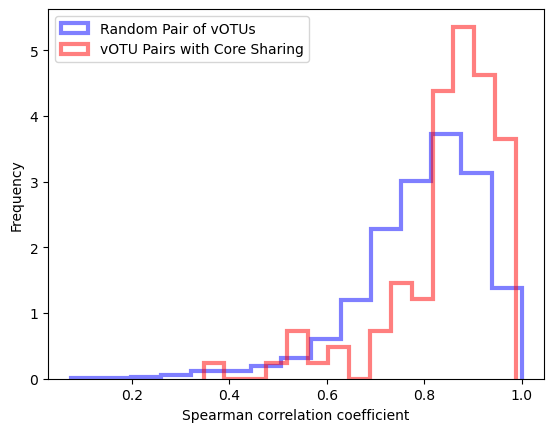

In [246]:
count_table=count_table_country[(count_table_country>0).any(axis=1)]
count_table=count_table[count_table.index.map(lambda x: votu_to_size[x]>=20)]
count_table_norm=count_table.div(count_table.sum(axis=1), axis=0)
for country in country_weights.keys():
    count_table_norm[country]=count_table_norm[country]+count_table_norm['NULL']*country_weights[country]
#drop null country
count_table_norm=count_table_norm.drop('NULL', axis=1)
print(count_table_norm)
#create set of all unique votus in count_table
votus=set()
for votu in count_table_norm.index:
    votus.add(votu)
corr_vals_random=[]
# Build the new row order: pair1, pair2, spacer, repeat
#extract all unique elements from all sets in votu_pairs
for i in range(0,10000):
    #pick random pair of votus
    v1, v2 = np.random.choice(list(votus), size=2, replace=False)
    if v1 in count_table_norm.index and v2 in count_table_norm.index:
        # Subset count_table_norm to rows with v1 and v2
        row1 = count_table_norm.loc[v1]
        row2 = count_table_norm.loc[v2]
        # Calculate the Pearson correlation coefficient between row1 and row2
        corr, p_value = stats.spearmanr(row1, row2)
        corr_vals_random.append(corr)
plt.hist(corr_vals_random, bins=15, alpha=0.5,histtype='step',label='Random Pair of vOTUs',density=True,color='blue',linewidth=3)
plt.hist(corr_vals, bins=15, alpha=0.5,histtype='step', label='vOTU Pairs with Core Sharing',density=True, color='red',linewidth=3)
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [176]:
#CREATE A HTML PROPORTIONAL MAP OF VOTU PRESENCE ACROSS THE GLOBE
#--->CAN MODIFY TO BE ALL VOTUS OR SPECIFIC VOTU
##############################################################################
import folium
import pandas as pd
from collections import Counter

z = list(zip(lats, longs,votus))
#remove 0,0 coordinates
z=[(lat,long,votu) for lat,long,votu in z if lat!=0 and long!=0]

#focus on specific votu
focal_votu='vOTU-047618'

#subset z to only include the focal votu
z=[(lat,long,votu) for lat,long,votu in z if votu==focal_votu]

# Find unique combinations of latitudes and longitudes and count instances
counts = Counter(z)

# Initialize an empty list to store the results
lat_long = []

# Iterate through counts and append to the list
for key, value in counts.items():
    lat_long.append([key[0], key[1], value])

# Convert the list into a DataFrame
df = pd.DataFrame(lat_long, columns=['Latitude', 'Longitude', 'Count'])
df = df[(df['Latitude'] != 0) | (df['Longitude'] != 0)]

# Create a base map centered globally (around [0, 0]) and no zoom to show the whole globe
m = folium.Map(location=[0, 0], zoom_start=1)

# Define a size scale based on the counts (you can adjust this factor to control the scaling)
size_factor = 100  # Adjust this to make the circles larger or smaller
total_number=sum(df['Count'])
# Add circle markers to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Count']/total_number * size_factor,  # Size proportional to count
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Count: {row['Count']}"
        
    ).add_to(m)


# Save the map to an HTML file
#m.save(f"/Users/jferrare/Downloads/{focal_votu}_proportional_map.html")
m.save("/Users/jferrare/Downloads/new_proportional_map_047618.html")




In [177]:
#EXAMINE SIMILARITY OF VOTUS IN SOUTH AMERICA AND AFRICA TO VOTUS IN OTHER CONTINENTS
##############################################################################
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt

sa_votus=['vOTU-055242','vOTU-000396','vOTU-000434','vOTU-000457','vOTU-001286']
core_votu_055242='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-055242_n39.fna'
core_votu_000396='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-000396_n102.fna'
core_votu_000434='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-000434_n105.fna'
core_votu_000457='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-000457_n62.fna'
core_votu_001286='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-001286_n37.fna'
sa_als=[core_votu_055242,core_votu_000396,core_votu_000434,core_votu_000457,core_votu_001286]

af_votus=["vOTU-000198","vOTU-002075","vOTU-000049","vOTU-000115","vOTU-001323"]
core_votu_000198='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-000198_n99.fna'
core_votu_002075='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-002075_n60.fna'
core_votu_000049='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-000049_n162.fna'
core_votu_000115='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-000115_n141.fna'
core_votu_001323='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments/core_alignment_vOTU-001323_n65.fna'
af_als=[core_votu_000198,core_votu_002075,core_votu_000049,core_votu_000115,core_votu_001323]

# Define a function to calculate the absolute distance between latitudes and longitudes using vectorized NumPy operations
def calculate_distance(lat1, lon1, lat2, lon2):

    # Convert latitude and longitude to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    R = 6371  # Earth radius in kilometers
    distance = R * c  # Distance in kilometers
    
    return distance


def calculate_heterozygosity(seq1, seq2):
    seq1_arr = np.array(list(seq1))
    seq2_arr = np.array(list(seq2))

    valid_sites = (seq1_arr != '-') & (seq2_arr != '-') & (seq1_arr != 'N') & (seq2_arr != 'N')

    heterozygous_sites = np.sum((seq1_arr != seq2_arr) & valid_sites)
    
    total_valid_sites = np.sum(valid_sites)
    heterozygosity = heterozygous_sites / total_valid_sites if total_valid_sites > 0 else 0
    
    return heterozygosity

def plot(file):
    heterozygosities = []
    distances = []
    heterozygosities_sa = []
    distances_sa = []
    #open core_votu_055242 and iterate over each unique pair.
    with open(file) as f:
        records = list(SeqIO.parse(f, 'fasta'))
    for i in range(0,len(records)):
        for j in range(i+1,len(records)):
            seq1 = records[i].seq
            seq2 = records[j].seq
            id1=records[i].id
            id2=records[j].id
            lat1=sequence_to_lat_long[id1][0]
            long1=sequence_to_lat_long[id1][1]
            lat2=sequence_to_lat_long[id2][0]
            long2=sequence_to_lat_long[id2][1]
            distance = calculate_distance(lat1, long1, lat2, long2)
            heterozygosity = calculate_heterozygosity(seq1, seq2)
            cont1=sequence_to_continent[id1]
            cont2=sequence_to_continent[id2]
            if cont2=='South America' or cont1=='South America':
                heterozygosities_sa.append(heterozygosity)
                distances_sa.append(distance+.1)
            else:
                heterozygosities.append(heterozygosity)
                distances.append(distance+.1)

    # Scatter plot of pairwise heterozygosity vs. distance
    plt.title('Core Genome Heterozygosity ')
    plt.scatter(distances, heterozygosities,alpha=.5,color='blue',label='Neither in South America')
    plt.scatter(distances_sa, heterozygosities_sa,alpha=.5,color='red',label='One Sequence in South America')
    plt.xlabel('Distance (km)')
    plt.ylabel('Pairwise heterozygosity')
    name=file.split('_')[-2].split('.')[0]
    plt.title(f'Genome pairs in different continents {name}')
    plt.legend()
    plt.xscale('log')
    #add histogram line on right hand side
    plt.show()
for file in sa_als:
    plot(file)



NameError: name 'sequence_to_lat_long' is not defined